In [1]:
from dotenv import load_dotenv
import fmpsdk
import pandas as pd
import os

load_dotenv()
apikey = os.environ.get("apikey")
snp500 = pd.DataFrame(fmpsdk.sp500_constituent(apikey))


from fetch import *

file_directories = ['financial-ratios-quarter-20220820.csv']
key_list = [PBR_KEY, PER_KEY]
key = key_list[0]

fetcher = Fetcher()
fetcher.register(key_list=key_list, csv_file_directory=file_directories[0])
from strategy import *

selector_small_pbr = Selector(type=SelectorType.HORIZON_RANGE, key=PBR_KEY, value=(0.0, 2.0), horizon=2)
selector_sequence = SelectorSequence(selectors=[selector_small_pbr])
filter_small_pbr = Filter(selector_sequence_union=[selector_sequence], name="small-pbr")

selector_large_pbr = Selector(type=SelectorType.HORIZON_RANGE, key=PBR_KEY, value=(3.0, 100.0), horizon=2)
selector_sequence = SelectorSequence(selectors=[selector_large_pbr])
filter_large_pbr = Filter(selector_sequence_union=[selector_sequence], name="large-pbr")


In [2]:
initial_holdings = [Asset(symbol=symbol) for symbol in snp500['symbol']]
start_date = datetime.date(2002,1,1)
end_date = datetime.date(2022,1,1)
rebalance_dates = pd.date_range(start_date, end_date, freq='1Y')

filter_list = [filter_small_pbr, filter_large_pbr]

strategist_list = []
for filter_ in filter_list:
    strategist_name = filter_.name
    strategist = Strategist(fetcher=fetcher, name=strategist_name, asset_pool=initial_holdings,
                            start_date=start_date, end_date=end_date)
    for rebalance_date in rebalance_dates:
        strategist.select_assets(filter=filter_, rebalance_date=rebalance_date.date())
    strategist_list.append(strategist)

In [4]:
from analyze import Analyst

analyst = Analyst(fetcher=fetcher)
analyst.register(table_name='price_list', csv_file_directory='snp500_price_list_19620102_20220814.csv')
analyst.register(table_name='economic_indicators', csv_file_directory='snp500_price_list_19620102_20220814.csv')

for strategist in strategist_list:
    analyst.attach(strategist)

# analyst.update_assets_property(PBR_KEY)
# analyst.update_assets_property(PER_KEY)

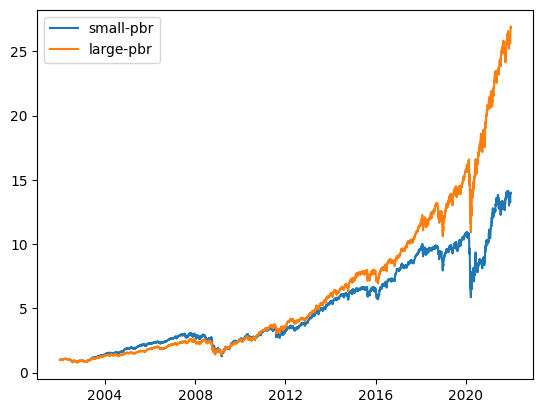

In [5]:
import matplotlib.pyplot as plt
from analyze import StrategyReport

for strategy_key in analyst.strategy_report_dict.keys():
    report: StrategyReport = analyst.strategy_report_dict[strategy_key]
    plt.plot(report.account_history, label=report.name)
plt.legend()